In [1]:
import cv2
import os 
import PIL
from matplotlib import pyplot as plt
import numpy as np 
import time

import random as rnd

from skimage.feature import hog, greycoprops, greycomatrix
from skimage import data, exposure

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score

In [2]:
def hog_feature(img, orientation, pxls_cell, cells_block, multichannel=False, transform_sqrt = True, feature_vect = True):
    return hog(img, orientations= orientation , pixels_per_cell=(pxls_cell, pxls_cell), \
               cells_per_block=(cells_block, cells_block),block_norm ='L2-Hys', transform_sqrt = transform_sqrt,\
               multichannel=multichannel, feature_vector = feature_vect)
    
def color_hist(img, bins_amount):
    ch1_hist = np.histogram(img[:,:,0], bins =bins_amount)
    ch2_hist = np.histogram(img[:,:,1], bins =bins_amount)
    ch3_hist = np.histogram(img[:,:,2], bins =bins_amount)
    return np.concatenate((ch1_hist[0] ,ch2_hist[0], ch3_hist[0]))

def hu_moments(img):
    return cv2.HuMoments(cv2.moments(img)).flatten()

def gray_co_feature(img, distance, angles, lvl):
    glcm = greycomatrix(img, distance, angles, levels = lvl, normed=True, symmetric = True)
    
    properties = ['contrast', 'ASM','energy', 'homogeneity', 'correlation', 'dissimilarity']
    feature_vector = np.zeros(len(distance)*len(angles)*len(properties))
    
    for i in range(len(properties)):
        feature_vector[i] = greycoprops(glcm, properties[i])[0, 0]
    
    return feature_vector

In [3]:
def L2_normalize(vector):
    norm = np.linalg.norm(vector)
    if norm != 0:
        return vector/norm
    else:
        print('norm equal to 0')

In [4]:
def get_features(img, orientation, pxls_cell, cell_block, bins_amount,\
                 distance, angles, lvl, color_histogram = True, HOG = True, hu =True,\
                haralick = True):
    
    feature_list = []
    
    if color_histogram == True:
        hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        color_hist_feature = color_hist(hsv_img, bins_amount)
        color_hist_feature = L2_normalize(color_hist_feature)
        feature_list.append(color_hist_feature)
    
    if (hu == True) or (hog == True) or (haralick == True):
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        
    if HOG == True:
        hog_features = np.ravel(hog_feature(gray_img, orientation, pxls_cell, cell_block))
        feature_list.append(hog_features)
        
    if hu == True:    
        hu_moments_feature = hu_moments(gray_img)
        feature_list.append(hu_moments_feature)
        
    if haralick == True:    
        Haralick_feature = gray_co_feature(gray_img, distance, angles, lvl)
        Haralick_feature = L2_normalize(Haralick_feature)
        feature_list.append(Haralick_feature)
     
    if len(feature_list) == 2:
        feature_vector = np.concatenate((feature_list[0], feature_list[1]))
    
    elif len(feature_list) == 3:
        feature_vector = np.concatenate((feature_list[0], feature_list[1], feature_list[2]))
    
    elif len(feature_list) == 4:
        feature_vector = np.concatenate((feature_list[0], feature_list[1], feature_list[2], feature_list[3]))
    
    else:
        feature_vector = feature_list[0]
        
    return feature_vector
    

In [8]:
def setup_train_data(pos, pos_path, neg, neg_path, orientation, pxls_cell, cell_block, bins_amount,\
                 distance, angles, lvl, color_histogram = True, HOG = True, hu =True,\
                haralick = True):
    ship_features = []
    no_ship_features = []
    
    for img_name in pos:
        img = cv2.imread(pos_path + "\\" + img_name)
        img = cv2.cvtColor(img,  cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (64,64))
        img = cv2.GaussianBlur(img, (3,3), 0)
        img_features = get_features(img, orientation, pxls_cell, cell_block, bins_amount,\
                                   distance, angles, lvl, color_histogram = color_histogram, HOG = HOG, hu = hu,\
                haralick = haralick)
        ship_features.append(img_features)
        
    for img_name in neg:
        img = cv2.imread(neg_path + "\\" + img_name)
        img = cv2.cvtColor(img,  cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (64,64))
        img = cv2.GaussianBlur(img, (3,3), 0)
        img_features = get_features(img, orientation, pxls_cell, cell_block, bins_amount,\
                                    distance, angles, lvl, color_histogram = color_histogram, HOG = HOG, hu = hu,\
                haralick = haralick)
        no_ship_features.append(img_features)
    
    # вектор векторов фич
    X = np.vstack((ship_features, no_ship_features)).astype(np.float64)
    # создание скейлера для фич
    X_scaler = StandardScaler().fit(X)
    # применение скейлера
    X_scaled = X_scaler.transform(X)
    y = np.hstack((np.ones(len(ship_features)), np.zeros(len(no_ship_features))))
    
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 5)
    
    return X_train, X_test, y_train, y_test, X_scaler

In [9]:
def train_SVC(x_train, y_train):
#     svc = svm.LinearSVC()
    svc = svm.SVC(kernel = 'rbf', gamma = 'auto')
    
    t = time.time()
    svc.fit(x_train, y_train)
    t2 = time.time()
    print(t2-t, 'seconds for svm trainnig')
    return svc

def train_RF(x_train, y_train):
    rfc = RandomForestClassifier(n_estimators=170, max_depth=6, random_state=0, max_features='sqrt')
    
    t = time.time()
    rfc.fit(x_train, y_train)
    t2 = time.time()
    print(t2-t, 'seconds to train random forest')
    return rfc
    

In [10]:
def detect_ships(path, img_name, orientation, pxls_cell, cell_block, bins_amount,\
                               distance, angles, lvl, res_path, color_histogram = True, HOG = True, hu = True,\
                haralick = True, clf = 'rf', ):
    
    image = cv2.imread(path + "\\" + img_name) #00dc34840
    image = cv2.cvtColor(image,  cv2.COLOR_BGR2RGB)

    tmp = image 
    step_size = 128 
    res_size = int((step_size/2))

    (w_w, w_h) = (step_size, step_size) # window size

    f_list = []
    
    i=0
    
    for y in range(0, image.shape[0], step_size):
        for x in range(0, image.shape[1], step_size):
            i += 1
            window = image[y: y + w_h, x: x + w_w]
            window = cv2.resize(window, (64, 64))
            window = cv2.GaussianBlur(window, (3,3), 0)
        
            features = get_features(window, orientation, pxls_cell, cell_block, bins_amount,\
                               distance, angles, lvl, color_histogram = color_histogram, HOG = HOG, hu = hu,\
                haralick = haralick).reshape(1,-1)

#         f_list.append(features)
            features = X_scaler.transform(features)
            if clf == 'rf':
                pred = rfc.predict(features)
            if clf == 'svm':
                pred = svc.predict(features)
#         print(pred)
        
            if pred == 1:
                print(pred, i)
                cv2.rectangle(tmp, (x + 5, y + 5), (x+w_w - 5, y + w_h - 5),(255,0,0),3)
#             cv2.rectangle(tmp, (x+30, y+30), (x+w_w+30, y + w_h+30),(0,255,0),2)
                plt.imshow(np.array(tmp).astype('uint8'))
#             plt.show()

        plt.imshow(image)
        cv2.imwrite(os.path.join(res_path, img_name), cv2.cvtColor(image,  cv2.COLOR_BGR2RGB))

In [78]:
in_pos_path = "D:\\diplom\\positive_in"
in_neg_path = "D:\\diplom\\negative_in"

pos_list = os.listdir(in_pos_path)
neg_list = os.listdir(in_neg_path)

rnd.seed(3)
pos_list = rnd.sample(pos_list, 7500)

rnd.seed(4)
neg_list = rnd.sample(neg_list, 7500)


In [79]:
orientation = 9
pxls_cell = 8
cell_block = 2
bins_amount = 32
distance = [1]
angles = [0]
lvl = 256

color_feature = True
hog_vector = False
hu_feature = True
grey_co_prop = True

In [80]:
print("Preparing data...")

t = time.time()
X_train, X_test, y_train, y_test, X_scaler = \
setup_train_data(pos_list, in_pos_path, neg_list, in_neg_path, orientation, pxls_cell, cell_block, bins_amount,\
                 distance, angles, lvl,\
                 color_histogram = color_feature ,hu = hu_feature, HOG = hog_vector, haralick = grey_co_prop )
t2 = time.time()

print("Time of data preparation in seconds:", t2-t)
print("Amount of train samples:", len(X_train))
print("Amount of test samples:", len(X_test))

Preparing data...
Time of data preparation in seconds: 622.5416150093079
Amount of train samples: 12000
Amount of test samples: 3000


# обучение СВМ

In [81]:
print("Trainig in process...")
svc = train_SVC(X_train, y_train)

Trainig in process...
26.066033363342285 seconds for svm trainnig


In [82]:
y_pred = svc.predict(X_test)

print("SVM RESULT \n","Accuracy:", accuracy_score(y_test, y_pred), '\n')
print(classification_report(y_test, y_pred))

SVM RESULT 
 Accuracy: 0.9083333333333333 

              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91      1513
         1.0       0.92      0.89      0.91      1487

   micro avg       0.91      0.91      0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



# обучение рандомного леса

In [83]:
print("Training in progress...")
rfc = train_RF(X_train, y_train)

Training in progress...
18.81474781036377 seconds to train random forest


In [84]:
y_pred = rfc.predict(X_test)

print("Random Forest result \n""Accuracy:", accuracy_score(y_test, y_pred), '\n')
print(classification_report(y_test, y_pred))

Random Forest result 
Accuracy: 0.887 

              precision    recall  f1-score   support

         0.0       0.87      0.91      0.89      1513
         1.0       0.91      0.86      0.88      1487

   micro avg       0.89      0.89      0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000



In [85]:
test_path = "D:\\diplom\\test_v2"
res_path_rf = "D:\\diplom_res\\res\\rf"
res_path_svm = "D:\\diplom_res\\res\\svm"
img_names = np.array(["0b7359c38.jpg","0af2a41e9.jpg","000f7d875.jpg",\
                      "0b38b9904.jpg","00a3ab3cc.jpg", "0d8c36745.jpg","0e0fb75c9.jpg"])

In [86]:
'''
0af2a41e9 город
000f7d875 небо
0b38b9904 облако
0b7359c38 просто корабль
00a3ab3cc просто корабли
0d8c36745 корабль, который плохо видно
0e0fb75c9 лодка со шлейфом
'''

'\n0af2a41e9 город\n000f7d875 небо\n0b38b9904 облако\n0b7359c38 просто корабль\n00a3ab3cc просто корабли\n0d8c36745 корабль, который плохо видно\n0e0fb75c9 лодка со шлейфом\n'

[1.] 19
[1.] 20
[1.] 21
[1.] 22
[1.] 26
[1.] 6
[1.] 8
[1.] 13
[1.] 14
[1.] 18
[1.] 23
[1.] 25
[1.] 28
[1.] 31
[1.] 32
[1.] 33
[1.] 34
[1.] 10
[1.] 11
[1.] 13
[1.] 14
[1.] 16
[1.] 18
[1.] 24
[1.] 25
[1.] 27
[1.] 29
[1.] 30
[1.] 34
[1.] 36
[1.] 9
[1.] 14
[1.] 30
[1.] 3
[1.] 9
[1.] 20
[1.] 26
[1.] 27
[1.] 32
[1.] 33
[1.] 5
[1.] 16
[1.] 20
[1.] 27
[1.] 28
[1.] 33


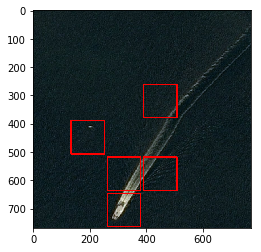

In [87]:
for name in img_names : detect_ships(test_path, name, orientation, pxls_cell, cell_block, bins_amount,\
                               distance, angles, lvl, res_path_svm,\
                 color_histogram = color_feature ,hu = hu_feature, HOG = hog_vector, haralick = grey_co_prop, clf = 'svm')

[1.] 9
[1.] 10
[1.] 13
[1.] 14
[1.] 15
[1.] 17
[1.] 18
[1.] 19
[1.] 25
[1.] 26
[1.] 27
[1.] 28
[1.] 29
[1.] 34
[1.] 36
[1.] 3
[1.] 9
[1.] 20
[1.] 26
[1.] 27
[1.] 32
[1.] 33
[1.] 13
[1.] 20
[1.] 21
[1.] 6
[1.] 10
[1.] 12
[1.] 14
[1.] 15
[1.] 16
[1.] 18
[1.] 20
[1.] 24
[1.] 26
[1.] 27
[1.] 29
[1.] 30
[1.] 32
[1.] 33
[1.] 34
[1.] 36
[1.] 6
[1.] 8
[1.] 12
[1.] 13
[1.] 14
[1.] 26
[1.] 27
[1.] 31
[1.] 32
[1.] 33
[1.] 34
[1.] 14
[1.] 30
[1.] 19
[1.] 20
[1.] 21
[1.] 22
[1.] 35
[1.] 36
[1.] 18
[1.] 5
[1.] 11
[1.] 16
[1.] 17
[1.] 20
[1.] 22
[1.] 27
[1.] 28
[1.] 33
[1.] 33
[1.] 15
[1.] 19
[1.] 20
[1.] 29
[1.] 35
[1.] 36
[1.] 4
[1.] 5
[1.] 14
[1.] 21
[1.] 22
[1.] 7
[1.] 16
[1.] 17
[1.] 18
[1.] 24
[1.] 26
[1.] 27
[1.] 29
[1.] 30
[1.] 31
[1.] 32
[1.] 33
[1.] 34
[1.] 35
[1.] 36
[1.] 3
[1.] 4
[1.] 5
[1.] 6
[1.] 7
[1.] 10
[1.] 11
[1.] 12
[1.] 13
[1.] 17
[1.] 18
[1.] 21
[1.] 27
[1.] 30
[1.] 33
[1.] 34
[1.] 36
[1.] 1
[1.] 2
[1.] 3
[1.] 4
[1.] 8
[1.] 9
[1.] 10
[1.] 11
[1.] 14
[1.] 16
[1.] 17
[1.] 19
[1.] 

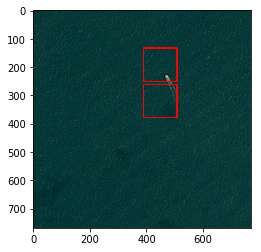

In [133]:
for name in img_names : detect_ships(test_path, name, orientation, pxls_cell, cell_block, bins_amount,\
                               distance, angles, lvl, res_path_rf,\
                 color_histogram = color_feature ,hu = hu_feature, HOG = hog_vector, haralick = grey_co_prop, clf = 'rf')